# Cells for Google Colab

In [1]:
import os
runningFromColab = False
if 'CGROUP_MEMORY_EVENTS' in os.environ and 'colab' in os.environ['CGROUP_MEMORY_EVENTS']:
  runningFromColab = True

In [2]:
if runningFromColab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if runningFromColab:
  %cd /content/drive/MyDrive/ColabProjects

/content/drive/MyDrive/ColabProjects


In [13]:
if runningFromColab:
  !git clone https://github.com/OdyAsh/nlp-image-captioning.git

fatal: destination path 'nlp-image-captioning' already exists and is not an empty directory.


In [4]:
if runningFromColab:
  %cd /content/drive/MyDrive/ColabProjects/nlp-image-captioning

/content/drive/MyDrive/ColabProjects/nlp-image-captioning


In [14]:
if runningFromColab:
  !git pull
  # if it DOES NOT say "Already up to date.", then you need to close this notebook file (i.e., the browser tab) and open it again for it to change 

Already up to date.


In [10]:
# if runningFromColab:
#   try:
#     import condacolab
#     condacolab.install()
#   except:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     # now restart the kernel

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [13]:
# if runningFromColab:
#   !conda env create -f environment.yml
#   # !conda update conda -y -q
#   # !source /usr/local/etc/profile.d/conda.sh
#   # !conda init 
#   # !conda install -n root _license -y -q
#   # !source activate myenv


CondaValueError: could not parse 'name: .conda' in: environment.yml



In [ ]:
# if runningFromColab:
#   import sys
#   sys.path.insert(0, '/usr/local/bin/conda')

# Courese Work 1 Requirements
to do: remove this markdown <br><br>
<img src="project_media/cw1_requirements.png" width="500" />

# Imports & Global Functions/Variables

In [2]:
from pprint import pprint
from glob import glob
from time import time
import os
import pickle
import regex as re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Add # merge.add
from tensorflow.keras.applications import inception_v3 # inception_v3.preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import preprocessing # preprocessing.image, preprocessing.sequence, preprocessing.text.Tokenizer, preprocessing.sequence.pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shehab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    return content

def pklForceLoad(path, dtype = 'dict'):
    try:
        content = pklLoad(path)
        return content
    except Exception as e:
        if dtype == 'list':
            pklSave([], path)
            return []
        else:
            pklSave({}, path)
            return {}

# more about naming standards for path components here: https://stackoverflow.com/questions/2235173/what-is-the-naming-standard-for-path-components
def joinPaths(baseDirectory, relativePath):
    return os.path.normpath(os.path.join(baseDirectory, relativePath))

In [5]:
datasetImgsBasePath = 'dataset/Flicker8k_Dataset/'
fullImgsPath = glob(datasetImgsBasePath + '*.jpg')
fullImgsPaths = [os.path.normpath(path) for path in fullImgsPath]
len(fullImgsPaths)

8091

# Data Collection
The dataset is obtained from [here](https://forms.illinois.edu/sec/1713398)

In [6]:
# checking the 5 captions per image
filename = "dataset/Flicker8k_TextFiles/Flickr8k.token.txt"
with open(filename, 'r') as f:
    doc = f.read()
lines = doc.split('\n')
print('first image\'s captions:')
pprint(lines[:5])
print('\nsecond image\'s captions:')
pprint(lines[5:10])
print('\nand so forth...')

first image's captions:
['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of '
 'stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse '
 '.',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her '
 'playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a '
 'wooden cabin .']

second image's captions:
['1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with '
 'each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots '
 'are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each '
 'other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

and s

The captions above are for these two images:

<img src="project_media/1000268201_693b08cb0e.jpg" width="100" />

<img src="project_media/1001773457_577c3a7d70.jpg" width="150" />

# Data Cleaning

In [7]:
# getting these captions in a dictionary; where the key is the image's name (without .jpg) and the value is a list of 5 captions
imgToCaptions = dict()
for line in lines:
    idAndCaption = re.split("\..+\t", line)
    if len(idAndCaption) < 2:
        continue
    imgId, caption = idAndCaption
    if imgId not in imgToCaptions:
        imgToCaptions[imgId] = list()
    imgToCaptions[imgId].append(caption)
    
imgToCaptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
# removing punctuation using maketrans (i.e., translation table)
# more about maketrans method: https://www.w3schools.com/python/ref_string_maketrans.asp#:~:text=The%20third%20parameter%20in%20the%20mapping%20table%20describes%20characters%20that%20you%20want%20to%20remove%20from%20the%20string%3A

# to do: ASK Dr: should I remove numbers/stopwords for image captioning task?

def cleanCaptions(imgToCaptions, levelOfStopwordsPresence=1):
    table = str.maketrans('', '', string.punctuation) # third argument: removes any character in this list: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for key, descList in imgToCaptions.items():
        # when this for loop is done, all 5 captions of an image will be cleaned
        for i in range(len(descList)):
            desc = descList[i]
            desc = desc.split(' ')
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc] # remove punctuation from each token
            stopswordsToRemove = []
            if levelOfStopwordsPresence == 1:
                stopswordsToRemove = ['a', 'an', 'the']
            elif levelOfStopwordsPresence >= 2:
                stopswordsToRemove = set(stopwords.words('english'))
            desc = [word for word in desc if word not in stopswordsToRemove]
            desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
            descList[i] =  ' '.join(desc) # store as string

# cleanCaptions(imgToCaptions, levelOfStopwordsPresence=1)
# pklSave(imgToCaptions, 'dataset/pickles/imgToCaptionsSWKept.pickle')
imgToCaptions = pklLoad('dataset/pickles/imgToCaptionsSWKept.pickle')
imgToCaptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

example with stopwords removed:
<br><br>
'little girl climbing stairs playhouse',

<br>
example with only ['a', 'an', 'the'] removed:
<br><br>
'little girl climbing stairs to her playhouse',
<br><br>
from the lack of context seen above, we've decided to keep the rest of the stopwords

In [9]:
# creating vocab of unique words (where each word occured at least freqThreshold number of times)
def createVocab(freqThreshold = 10):
    vocab = set()
    for key in imgToCaptions.keys():
        [vocab.update(desc.split()) for desc in imgToCaptions[key]]
    print(f'Original vocabulary (i.e., unique words) size: {len(vocab)}')

    # keeping words that appear at least freqThrehold number of times
    # ASK DR: should i do that? or retain all words? should this be considered a hyperparameter?
    vocabWordFreq = {key: 0 for key in vocab}
    for key, descs in imgToCaptions.items():
        for desc in descs:
            descList = desc.split(' ')
            for word in descList:
                if word != '':
                    vocabWordFreq[word] += 1
    
    vocab = set()
    vocabWordFreqFinal = dict()
    i = 0
    for word, freq in vocabWordFreq.items():
        if freq >= freqThreshold:
            i += 1
            vocab.add(word)
            vocabWordFreqFinal[word] = freq
    print(f'Vocabulary size after removing less frequent words (< {freqThreshold} words): {len(vocab)}')

    vocabWordFreqRemoved = {word: freq for word, freq in vocabWordFreq.items() if word not in vocabWordFreqFinal}

    return vocab, vocabWordFreqFinal, vocabWordFreqRemoved

def createVocabTxtFiles(vocabWordFreqFinal, vocabWordFreqRemoved, filePrefix="vocabFreqThreshold"):
    with open(f'dataset/{filePrefix}Final.txt', 'w') as f:
        f.write(str(dict(sorted(vocabWordFreqFinal.items(), key=lambda x: x[1], reverse=True))))
    with open(f'dataset/{filePrefix}Removed.txt', 'w') as f:
        f.write(str(dict(sorted(vocabWordFreqRemoved.items(), key=lambda x: x[1], reverse=True))))

vocab, vocabWordFreqFinal, vocabWordFreqRemoved = createVocab(freqThreshold=5)
createVocabTxtFiles(vocabWordFreqFinal, vocabWordFreqRemoved, filePrefix=f"vocabFreqThreshold5")

Original vocabulary (i.e., unique words) size: 8366
Vocabulary size after removing less frequent words (< 5 words): 2945


In [10]:
#  function to get filenames of images from a text file (without the extension)
def getImgsIdsList(txtPath):
    with open(txtPath, 'r') as f:
        doc = f.read()
    ImgsIds = []
    for line in doc.split('\n'):
        imgId = line.split('.')[0]
        ImgsIds.append(imgId)
    ImgsIds = [id for id in ImgsIds if id != '']
    return ImgsIds

trainImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.trainImages.txt')
valImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.devImages.txt')
testImgsIds = getImgsIdsList('dataset/Flicker8k_TextFiles/Flickr_8k.testImages.txt')
print(f'Train Dataset: {len(trainImgsIds)}')
print(f'Validation Dataset: {len(valImgsIds)}')
print(f'Test Dataset: {len(testImgsIds)}')

Train Dataset: 6000
Validation Dataset: 1000
Test Dataset: 1000


In [11]:
trainImgToCaptions = dict()
valImgToCaptions = dict()
testImgToCaptions = dict()
for imgId in trainImgsIds:
    trainImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
for imgId in valImgsIds:
    valImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
for imgId in testImgsIds:
    testImgToCaptions[imgId] = ['startseq ' + desc + ' endseq' for desc in imgToCaptions[imgId]]
print(f'images in training set: {len(trainImgToCaptions)}\n')
print(f'images in validation set: {len(valImgToCaptions)}\n')
print(f'images in testing set: {len(testImgToCaptions)}\n')
print('example from training set:')
pprint(trainImgToCaptions['2513260012_03d33305cf'])

images in training set: 6000

images in validation set: 1000

images in testing set: 1000

example from training set:
['startseq black dog is running after white dog in snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across snowy ground endseq',
 'startseq two dogs play together in snow endseq',
 'startseq two dogs running through low lying body of water endseq']


# Preparing File Paths

In [12]:
trainImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in trainImgToCaptions.keys()]
valImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in valImgToCaptions.keys()]
testImgsPaths = [joinPaths(datasetImgsBasePath, imgId)+'.jpg' for imgId in testImgToCaptions.keys()]
len(trainImgsPaths), len(valImgsPaths), len(testImgsPaths)

(6000, 1000, 1000)

# Data Pre-Processing

## Pre-Processing Images

In [13]:
# getting the feature vector of each image using the InceptionV3 CNN model created by Google Research
model = InceptionV3(weights='imagenet') # getting the InceptionV3 model trained on imagenet data
model.layers[-1].output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [14]:
modelForFeatureExtraction = Model(model.input, model.layers[-2].output) # removing the last layer (output softmax layer)
modelForFeatureExtraction.layers[-1].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [15]:
# function to preprocess the input image
def preprocess(imgPath):
    pilImg = preprocessing.image.load_img(imgPath, target_size=(299, 299)) # Convert all the images to size 299x299 as expected by the inception v3 model
    x = preprocessing.image.img_to_array(pilImg) # Convert PIL image to numpy array of 3-dimensions
    x = np.expand_dims(x, axis=0) # Add one more dimension; from (299, 299, 3) to (1, 299, 299, 3)
    x = inception_v3.preprocess_input(x) # takes in (batch_size, height, width, channels), returns same dimensions, but does some preprocessing operations, like scaling values to be from -1 to 1
    return x

# function to encode a given image (from its path) into a vector of size (2048, )
def encode(imgPath):
    imgPath = preprocess(imgPath) # preprocess the image
    featureVec = modelForFeatureExtraction.predict(imgPath) # Get the encoding vector for the image
    featureVec = np.reshape(featureVec, featureVec.shape[1]) # reshape from (1, 2048) to (2048, )
    return featureVec

In [16]:
# Call the funtion to encode all the train images (dictionary where an image id --> feature vector of length 2048)
# This will take a while on CPU - Execute this only once (took around 13 minutes on my high-end laptop)
def encodeImgToFeatures(imgsPaths):
    imgToFeatures = dict()
    for imgPath in imgsPaths:
        imgToFeatures[imgPath[len(datasetImgsBasePath):]] = encode(imgPath)
    return imgToFeatures

# trainImgToFeatures = encodeImgToFeatures(trainImgsPaths)
# valImgToFeatures = encodeImgToFeatures(valImgsPaths)
# testImgToFeatures = encodeImgToFeatures(testImgsPaths)
# pklSave(trainImgToFeatures, 'dataset/pickles/trainImgToFeatures.pickle')
# pklSave(valImgToFeatures, 'dataset/pickles/valImgToFeatures.pickle')
# pklSave(testImgToFeatures, 'dataset/pickles/testImgToFeatures.pickle')
trainImgToFeatures = pklLoad('dataset/pickles/trainImgToFeatures.pickle')
valImgToFeatures = pklLoad('dataset/pickles/valImgToFeatures.pickle')
testImgToFeatures = pklLoad('dataset/pickles/testImgToFeatures.pickle')
len(trainImgToFeatures), len(valImgToFeatures), len(testImgToFeatures), trainImgToFeatures['2513260012_03d33305cf.jpg'].shape

(6000, 1000, 1000, (2048,))

## Pre-Processing Captions

In [17]:
# creating two dictionaries: word to index, and index to word

def mapIdxAndWord(vocab):
    idxToWord = {}
    wordToIdx = {}
    idx = 1
    for word in vocab:
        wordToIdx[word] = idx
        idxToWord[idx] = word
        idx += 1
    return idxToWord, wordToIdx

vocab, _, _ = createVocab(freqThreshold=5)
idxToWord, wordToIdx = mapIdxAndWord(vocab)
vocabSize = len(idxToWord) + 1 # one for appended 0's; explained later
vocabSize

Original vocabulary (i.e., unique words) size: 8366
Vocabulary size after removing less frequent words (< 5 words): 2945


2946

In [18]:
# getting the length of the longest caption; as we will later need to encode each word into a fixed sized vector

# convert a dictionary of clean captions to a list of captions
def toCaptionsList(ImgToCaptions):
	captionsList = list()
	for imgId in ImgToCaptions.keys():
		[captionsList.append(caption) for caption in ImgToCaptions[imgId]]
	return captionsList

# calculate the length of the description with the most words
def maxCaptionLength(ImgToCaptions):
    captions = toCaptionsList(ImgToCaptions)
    captionsLengths = [len(caption.split()) for caption in captions]
    return max(captionsLengths)

# determine the maximum sequence length
maxCapLen = maxCaptionLength(trainImgToCaptions)
print(f'Description Length: {maxCapLen}')

Description Length: 32


# Preparing Model Generator

In [19]:
# data generator, intended to be used in a call to model.fit_generator()
def dataGenerator(imgToCaptions, imgToFeatures, wordToIdx, vocabSize, maxCaptionLength, imgsBatchSize):
    X1, X2, y = list(), list(), list()
    n=0
    # loop forever over images
    while True:
        for imgId, captions in imgToCaptions.items():
            n+=1
            imgFeatures = imgToFeatures[imgId+'.jpg'] # retrieve the image's feature vector
            for caption in captions:
                seq = [wordToIdx[word] for word in caption.split(' ') if word in wordToIdx] # encode the caption into a sequence of numbers instead of words
                for i in range(1, len(seq)): # split one sequence into multiple X, y pairs
                    inSeq, outSeq = seq[:i], seq[i] # split into input and output pair
                    inSeq = preprocessing.sequence.pad_sequences([inSeq], maxlen=maxCaptionLength)[0] # pad input sequence
                    outSeq = to_categorical([outSeq], num_classes=vocabSize)[0] # (one-hot) encodes the output sequence (note: to_categorical() is a keras-related function)
                    X1.append(imgFeatures) # store the values
                    X2.append(inSeq)
                    y.append(outSeq)
            # yield the batch data
            if n == imgsBatchSize:
                yield [[np.array(X1), np.array(X2)], np.array(y)] # "yield" saves the function's state, returns [[..]], then continues function from that statement when function is called again
                X1, X2, y = list(), list(), list()
                n=0

to do: insert the correct images
Visualization of the inner-most for loop (that deals with `inSeq` and `outSeq`):

<img src="project_media/aaa.png" width="300" />

However, since we're using `wordToIdx` mapping, the table above will be:

<img src="project_media/aaa.png" width="300" />



# Word Embedding

## Using Skip Grams

In [19]:
# import numpy as np
# import string
# from nltk.corpus import stopwords

# def softmax(x):
# 	e_x = np.exp(x - np.max(x))
# 	return e_x / e_x.sum()

# class word2vec(object):
# 	def __init__(self):
# 		self.N = 10
# 		self.X_train = []
# 		self.y_train = []
# 		self.window_size = 2
# 		self.alpha = 0.001
# 		self.words = []
# 		self.word_index = {}

# 	def initialize(self,V,data):
# 		self.V = V
# 		self.W = np.random.uniform(-0.8, 0.8, (self.V, self.N))
# 		self.W1 = np.random.uniform(-0.8, 0.8, (self.N, self.V))
		
# 		self.words = data
# 		for i in range(len(data)):
# 			self.word_index[data[i]] = i

	
# 	def feed_forward(self,X):
# 		self.h = np.dot(self.W.T,X).reshape(self.N,1)
# 		self.u = np.dot(self.W1.T,self.h)
# 		#print(self.u)
# 		self.y = softmax(self.u)
# 		return self.y
		
# 	def backpropagate(self,x,t):
# 		e = self.y - np.asarray(t).reshape(self.V,1)
# 		# e.shape is V x 1
# 		dLdW1 = np.dot(self.h,e.T)
# 		X = np.array(x).reshape(self.V,1)
# 		dLdW = np.dot(X, np.dot(self.W1,e).T)
# 		self.W1 = self.W1 - self.alpha*dLdW1
# 		self.W = self.W - self.alpha*dLdW
		
# 	def train(self,epochs):
# 		for x in range(1,epochs):	
# 			self.loss = 0
# 			for j in range(len(self.X_train)):
# 				self.feed_forward(self.X_train[j])
# 				self.backpropagate(self.X_train[j],self.y_train[j])
# 				C = 0
# 				for m in range(self.V):
# 					if(self.y_train[j][m]):
# 						self.loss += -1*self.u[m][0]
# 						C += 1
# 				self.loss += C*np.log(np.sum(np.exp(self.u)))
# 			print("epoch ",x, " loss = ",self.loss)
# 			self.alpha *= 1/( (1+self.alpha*x) )
			
# 	def predict(self,word,number_of_predictions):
# 		if word in self.words:
# 			index = self.word_index[word]
# 			X = [0 for i in range(self.V)]
# 			X[index] = 1
# 			prediction = self.feed_forward(X)
# 			output = {}
# 			for i in range(self.V):
# 				output[prediction[i][0]] = i
			
# 			top_context_words = []
# 			for k in sorted(output,reverse=True):
# 				top_context_words.append(self.words[output[k]])
# 				if(len(top_context_words)>=number_of_predictions):
# 					break
	
# 			return top_context_words
# 		else:
# 			print("Word not found in dictionary")


In [27]:
# def preprocessing(corpus):
#     stop_words = set(stopwords.words('english'))
#     training_data = []
#     captions=[]
#     for values in corpus.values():
#         captions.append(values)
        
#     for group in captions:
#         for caption in group:
#             caption = caption.split()
#             x = [word.strip(string.punctuation) for word in caption if word not in stop_words]
#             x = [word.lower() for word in x]
#             x.remove(x[0])
#             x.remove(x[-1])
#             training_data.append(x)
#     return training_data

# def prepare_data_for_training(sentences,w2v):
# 	data = {}
# 	for sentence in sentences:
# 		for word in sentence:
# 			if word not in data:
# 				data[word] = 1
# 			else:
# 				data[word] += 1
# 	V = len(data)
# 	data = sorted(list(data.keys()))
# 	vocab = {}
# 	for i in range(len(data)):
# 		vocab[data[i]] = i
	
# 	#for i in range(len(words)):
# 	for sentence in sentences:
# 		for i in range(len(sentence)):
# 			center_word = [0 for x in range(V)]
# 			center_word[vocab[sentence[i]]] = 1
# 			context = [0 for x in range(V)]
			
# 			for j in range(i-w2v.window_size,i+w2v.window_size):
# 				if i!=j and j>=0 and j<len(sentence):
# 					context[vocab[sentence[j]]] += 1
# 			w2v.X_train.append(center_word)
# 			w2v.y_train.append(context)
# 	w2v.initialize(V,data)

# 	return w2v.X_train,w2v.y_train


In [57]:
# epochs = 100

# training_data = preprocessing(trainImgToCaptions)
# w2v = word2vec()

# prepare_data_for_training(training_data,w2v)
# w2v.train(epochs)

# print(w2v.predict("chase",4))


In [28]:
# training_data = preprocessing(trainImgToCaptions)
# training_data

[['black', 'dog', 'running', 'white', 'dog', 'snow'],
 ['black', 'dog', 'chasing', 'brown', 'dog', 'snow'],
 ['two', 'dogs', 'chase', 'across', 'snowy', 'ground'],
 ['two', 'dogs', 'play', 'together', 'snow'],
 ['two', 'dogs', 'running', 'low', 'lying', 'body', 'water'],
 ['little', 'baby', 'plays', 'croquet'],
 ['little', 'girl', 'plays', 'croquet', 'next', 'truck'],
 ['child', 'playing', 'croquette', 'truck'],
 ['kid', 'front', 'car', 'put', 'ball'],
 ['little', 'boy', 'playing', 'croquet', 'hammer', 'ball', 'beside', 'car'],
 ['brown', 'dog', 'snow', 'something', 'hot', 'pink', 'mouth'],
 ['brown', 'dog', 'snow', 'holding', 'pink', 'hat'],
 ['brown', 'dog', 'holding', 'pink', 'shirt', 'snow'],
 ['dog', 'carrying', 'something', 'pink', 'mouth', 'walking', 'snow'],
 ['dog', 'something', 'pink', 'mouth', 'looking', 'forward'],
 ['brown', 'dog', 'running', 'along', 'beach'],
 ['brown', 'dog', 'wearing', 'black', 'collar', 'running', 'across', 'beach'],
 ['dog', 'walks', 'sand', 'near', 

In [76]:
# captions = []
# for values in trainImgToCaptions.values():
#     for caption in values:
#         caption = caption.split()
#         caption.remove(caption[0])
#         caption.remove(caption[-1])
#         caption = ' '.join(caption)
#         captions.append(caption)
        
# with open("training.txt", "w") as f:
#     for caption in captions:
#         f.write(caption + "")

In [52]:
# captions = []
# for values in testImgToCaptions.values():
#     for caption in values:
#         caption = caption.split()
#         caption.remove(caption[0])
#         caption.remove(caption[-1])
#         caption = ' '.join(caption)
#         captions.append(caption)
        
# with open("testing.txt", "w") as f:
#     for caption in captions:
#         f.write(caption + "")

In [54]:
# import torch
# import random
# import itertools
# import numpy as np
# import pandas as pd
# from collections import Counter
# from torch.utils.data import Dataset
# from tqdm.auto import tqdm
# import torch.nn as nn
# from torch.autograd import Variable
# from torch.utils.data import DataLoader
# from scipy.stats import spearmanr
# from scipy import spatial

# class Text8Dataset(Dataset):
#     def __init__(self, filename, size, sub_sampling_min, sub_sampling_t, window_size,
#                 neg_sampling_pool_size, neg_sampling_size, wordToIdx, idxToWord):
#         self.word2idx = wordToIdx
#         self.idx2word = idxToWord
#         self.window_size = window_size // 2
#         self.neg_sampling_size = neg_sampling_size
#         self.load_corpus(filename, size)
#         self.sub_sampling(sub_sampling_min, sub_sampling_t, True, True)
#         self.neg_sampling(neg_sampling_pool_size)

#     def __len__(self): 
#         return len(self.tokens)

#     def __getitem__(self, idx):
#         center = self.tokens[idx]
#         context = self.tokens[max(0, idx-self.window_size):
#                                 min(idx+self.window_size+1, len(self.tokens))]
#         context = [w for w in context if w != center]
#         center = [center] * len(context)
#         neg = self.get_neg_samples(center[0], len(center))
#         return (center, context, neg)

#     @staticmethod
#     def collate_fn(batches):
#         center_vec = torch.LongTensor(list(itertools.chain(*[batch[0] for batch in batches])))
#         context_vec = torch.LongTensor(list(itertools.chain(*[batch[1] for batch in batches])))
#         neg_mat = torch.LongTensor(np.vstack([batch[2] for batch in batches]))
#         return center_vec, context_vec, neg_mat

#     def load_corpus(self, filename, size):
#         with open(filename) as f:
#             self.tokens = list(f.readline().lower().split())[:size]
#         self.num_words = len(self.tokens)
#         self.word_set = set(self.tokens)
#         self.word_counter = Counter(self.tokens)

#     def sub_sampling(self, min_freq, t, sw: bool, sc: bool):

#         # df = pd.read_csv("wordsim353/combined.csv")
#         # wordsim353_words = set(df["Word 1"]) | set(df["Word 2"])
#         # if sw: stopwords = nltk.corpus.stopwords.words('english')
#         # for word, count in self.word_counter.items():
#         #     if word not in wordsim353_words and \
#         #     (count < min_freq or \
#         #     (sw and word in stopwords) or \
#         #     (sc and set(word) == set(word[0])) or \
#         #     np.random.uniform() < 1-np.sqrt(t/(count/self.num_words))):
#         #         self.word_set.discard(word)
#         self.tokens = [token for token in self.tokens if token in self.word_set]
#         self.tokens = [i[0] for i in itertools.groupby(self.tokens)]
#         self.word_counter = Counter(self.tokens)
#         for idx, word in enumerate(self.word_set):
#             if word not in self.word2idx:
#                 self.word2idx[word] = idx
#             self.idx2word[idx] = word
#         self.tokens = [self.word2idx[token] for token in self.tokens]

#     def neg_sampling(self, neg_sampling_pool_size):
#         self.neg_samples = []
#         total = np.sum(np.power(np.array(list(self.word_counter.values())), 3/4))
#         for word, count in self.word_counter.items():
#             prob = np.power(count, 3/4) / total
#             self.neg_samples += [self.word2idx[word]] * int(np.rint(prob * neg_sampling_pool_size))
#         random.shuffle(self.neg_samples)

#     def get_neg_samples(self, center, n):
#         samples = np.random.choice(self.neg_samples, size=(n, self.neg_sampling_size))
#         for i in range(samples.shape[0]):
#             for j in range(samples.shape[1]):
#                 while samples[i,j] == center:
#                     samples[i,j] = np.random.choice(self.neg_samples, size=1)[0]
#         return samples


# class SkipGram(nn.Module):
#     def __init__(self, vocab_size, embed_size):
#         super(SkipGram, self).__init__()
#         self.vocab_size = vocab_size
#         self.embed_size = embed_size
#         self.center_embeds = nn.Embedding(vocab_size, embed_size, sparse=True)
#         self.context_embeds = nn.Embedding(vocab_size, embed_size, sparse=True)
#         self.init_weights()

#     def init_weights(self):
#         irange = 0.5 / self.embed_size
#         nn.init.uniform_(self.center_embeds.weight.data, -irange, irange)
#         nn.init.constant_(self.context_embeds.weight.data, 0)

#     def forward(self, pos_center, pos_context, pos_neg_samples):
#         center_emb = self.center_embeds(Variable(pos_center))
#         context_emb = self.context_embeds(Variable(pos_context))
#         neg_emb = self.context_embeds(Variable(pos_neg_samples))

#         scores = torch.mul(center_emb, context_emb)
#         scores = torch.sum(scores, dim=1)
#         scores = nn.functional.logsigmoid(scores)

#         neg_scores = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze()
#         neg_scores = torch.sum(neg_scores, dim=1)
#         neg_scores = nn.functional.logsigmoid(-neg_scores)

#         return -(scores + neg_scores).sum() / pos_center.shape[0]


# # def calc_spearman(filename, model, dataset):
# #     ranks = []
# #     human = []
# #     df = pd.read_csv(filename)
# #     words1 = df["Word 1"].to_list()
# #     words2 = df["Word 2"].to_list()
# #     scores = df["mean"].tolist()
# #     embeddings = model.center_embeds
# #     for i in range(len(words1)):
# #         if words1[i] in dataset.word2idx and words2[i] in dataset.word2idx:
# #             word1_pos = dataset.word2idx[words1[i]]
# #             word2_pos = dataset.word2idx[words2[i]]
# #             word1_embed = embeddings(Variable(torch.LongTensor([word1_pos]).to(DEVICE))).cpu().detach().numpy().reshape(-1)
# #             word2_embed = embeddings(Variable(torch.LongTensor([word2_pos]).to(DEVICE))).cpu().detach().numpy().reshape(-1)
# #             cossim_score = 1 - spatial.distance.cosine(word1_embed, word2_embed)
# #             human.append(scores[i])
# #             ranks.append(cossim_score*10)
# #     df = pd.DataFrame(list(zip(human, ranks)))
# #     df.plot.scatter(0, 1, xlabel='Humans', ylabel='word2vec')
# #     return spearmanr(human, ranks).correlation

# def train(model, dataset, dataloader, optimizer, epochs, device):
#     loss_hist = []
#     for epoch in range(epochs):
#         epoch_loss_hist = []
#         for _, batch in enumerate(tqdm(dataloader)):
#             center, context, neg = batch
#             center = center.to(device)
#             context = context.to(device)
#             neg = neg.to(device)

#             optimizer.zero_grad()
#             loss = model(center, context, neg)
#             epoch_loss_hist.append(loss.item())
#             loss.backward()
#             optimizer.step()

#         loss_hist.append(np.mean(epoch_loss_hist))
#         print(f'epoch: {epoch+1} \t avg_loss={loss_hist[-1]}')
#         #print(f'epoch: {epoch+1} \t spearman_corr={calc_spearman("testing.txt", model, dataset)}')


# EPOCHS = 5
# WINDOW_SIZE = 5
# BATCH_SIZE = 1024
# SUB_SAMP_MIN = 5
# SUB_SAMP_T = 1e-5
# TRAIN_SIZE = -1
# LEARNING_RATE = 0.01
# NEG_SAMPLING_SIZE = 5
# NEG_SAMPLING_POOL_SIZE = 1e4
# EMBEDDING_DIM = 300
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# dataset = Text8Dataset("training.txt", TRAIN_SIZE, SUB_SAMP_MIN, SUB_SAMP_T, WINDOW_SIZE, NEG_SAMPLING_POOL_SIZE, NEG_SAMPLING_SIZE, wordToIdx, idxToWord)
# print(len(dataset.word2idx))
# print(dataset.__len__())
# model = SkipGram(len(dataset.word2idx), EMBEDDING_DIM).to(DEVICE)
# dataloader = DataLoader(dataset, collate_fn=dataset.collate_fn, batch_size=BATCH_SIZE)
# optimizer = torch.optim.SparseAdam(model.parameters())
# train(model, dataset, dataloader, optimizer, EPOCHS, DEVICE)

20418
230319


  0%|          | 0/225 [00:00<?, ?it/s]

epoch: 1 	 avg_loss=1.0891269980536566


  0%|          | 0/225 [00:00<?, ?it/s]

epoch: 2 	 avg_loss=0.9723537307315403


  0%|          | 0/225 [00:00<?, ?it/s]

epoch: 3 	 avg_loss=0.9190351451767815


  0%|          | 0/225 [00:00<?, ?it/s]

epoch: 4 	 avg_loss=0.8677226119571262


  0%|          | 0/225 [00:00<?, ?it/s]

epoch: 5 	 avg_loss=0.8267408066325718


Epoch: 1000 cost = 8.848490
Epoch: 2000 cost = 7.877069
Epoch: 3000 cost = 7.440543
Epoch: 4000 cost = 7.243413
Epoch: 5000 cost = 6.320783
tensor([[-6.8295e-02,  2.4982e-02,  6.8821e-01,  ..., -8.3622e-01,
          4.6826e-01,  8.6728e-01],
        [-8.7498e-01,  5.3718e-01, -9.3186e-01,  ...,  2.3188e-01,
          4.5757e-01, -6.6128e-01],
        [ 4.0366e-01, -8.2245e-01,  6.0813e-01,  ..., -7.4277e-01,
          4.3994e-01,  7.4775e-01],
        ...,
        [-8.0728e-01,  2.5866e-01,  4.0631e-01,  ...,  7.8659e-04,
         -1.1258e-01, -4.2169e-01],
        [-6.7512e-01,  8.9684e-01, -3.7807e-01,  ..., -4.9880e-01,
          2.1436e-01,  8.6066e-01],
        [-2.8757e-01, -2.6630e-01, -2.2269e-01,  ..., -8.2278e-01,
         -7.2129e-01,  5.4164e-01]])


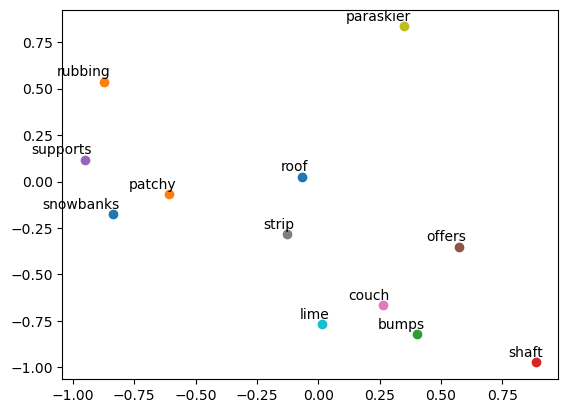

In [33]:
captions = []
word_sequence=[]
temp=[]
for values in trainImgToCaptions.values():
    for caption in values:
        captions.append(caption)
        
for values in testImgToCaptions.values():
    for caption in values:
        captions.append(caption)

for s in captions:
    s = s.split()       
    s.remove(s[0])
    s.remove(s[-1])
    temp.append(s)
for sentence in temp:
    for word in sentence:
        word_sequence.append(word)


dtype = torch.FloatTensor

# build the vocabulary
word_list = list(set(word_sequence))
#print(word_list)
word_dict = {w: i for i, w in enumerate(word_list)}
#print(word_dict)

# Word2Vec Parameter
batch_size = 20  
embedding_size = 32  
voc_size = len(word_list)

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 3):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 3]], word_dict[word_sequence[i + 3]]]

    for w in context:
        skip_grams.append([input, w])


#plot some data
#skip_grams[:6]
#np.random.seed(172)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        # one-hot encoding of words
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # input
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels

#random_batch(skip_grams[:6], size=3)

# inputs: like , i, dog , context: i, dog, i

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size -> embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size -> voc_size Weight

    def forward(self, X):
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        #return output_layer 
        return output_layer

model = Word2Vec()

# Set the model in train mode
model.train()

criterion = nn.CrossEntropyLoss() # Softmax (for multi-class classification problems) is already included
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Learned W
W, _= model.parameters()

torch.save(model.state_dict(), 'skip_gram')

print(W.detach())
for i, word in enumerate(word_list):
    W, _= model.parameters()
    W = W.detach()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    if i > 10:
        break
    
plt.show()

## Using Continuous Bag Of Words (CBOW)

In [19]:
# to do:
# code for embedding
# code for model architecture
# code for model training; provided here:

# epochs = 10
# numImgsPerBatch = 3
# steps = len(trainImgToCaptions)//numImgsPerBatch
# for i in range(1, epochs+1):
#     generator = dataGenerator(trainImgToCaptions, trainImgToFeatures, wordToIdx, maxCapLen, numImgsPerBatch)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save(f'models/changingEpochs/modelWith{str(i)}Epochs.h5')

# code for validating/testing (inference)